## SVM model for 4class audio with 100ms frame size

## Important Libraries 

In [2]:
import io
import time
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import svm, datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64

Using TensorFlow backend.


### Useful Functions

In [3]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

    # Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Read MFCCs feature CSV file of audio of 500ms block

In [5]:
path="/home/bsplab/Desktop/manikanta/SVM_Kflod/Traing_100ms/CRYING"
df=pd.read_csv("/home/bsplab/Desktop/manikanta/SVM_Kflod/Traing_100ms/CRYING/individual_100ms.csv",na_values=['NA','?'])
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
filename_write = os.path.join(path,"7class-out-of-sample_mySVM_100ms.csv")
df.head()


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-10.339339,-58.503360,28.969193,-16.135848,-0.850935,-7.166208,24.007454,-25.177117,7.820241,1.586773,-0.016230,-4.160415,-2.928838,crying
1,-10.255503,-58.766382,28.839630,-15.665957,0.201420,-7.582272,24.395316,-24.310047,9.044284,1.180245,1.338979,-2.547351,-3.876356,crying
2,-10.219711,-47.300163,29.763146,-17.593168,3.772775,-9.047093,18.010719,-21.991444,12.146181,-2.855262,-0.514320,-0.502388,-3.394465,crying
3,-10.335775,-36.359484,28.162880,-7.049695,27.120645,-3.100069,16.331104,-2.871143,28.954943,-1.509898,1.557353,5.172644,-2.621226,crying
4,-10.328217,-20.086843,13.868843,-5.345090,23.884885,-9.032826,10.503083,0.159714,21.487532,-3.494115,4.201391,3.049172,6.644954,crying


#### Shuffle

In [6]:
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.columns

Index(['MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
       'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'Label'],
      dtype='object')

In [7]:
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-5.604626,-8.172296,5.206748,-2.383627,-21.005279,16.550854,-22.240188,-2.184232,17.962110,-38.702665,30.683808,-23.026454,4.921159,speech
1,-1.771606,13.864471,-32.058541,10.250745,-21.167710,8.608871,-22.244622,-18.606278,2.309756,-15.449925,3.155800,-9.158134,3.111149,music
2,-2.758959,-6.394277,2.617576,1.732703,-27.661945,29.846086,-30.306968,0.760964,20.359883,-40.511891,41.736541,-25.518602,14.693751,speech
3,-3.917437,14.327343,-16.532813,0.810541,-12.540902,9.442987,-25.251732,-29.238576,10.375724,-26.777831,4.799518,-8.528685,-3.050550,music
4,-1.644729,-37.392616,-1.961913,48.395111,-30.597397,34.214259,8.289310,-25.629234,-2.689849,-10.126319,-8.749178,4.808536,-10.116423,speech


#### Sperating Independent variable and Target Variable

In [8]:
X = df[['MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
       'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12']]
y = df['Label']

#### Encode to a 2D matrix for training

In [9]:
# Encode to a 2D matrix for training
Label=encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

Labelling is:['ac' 'crying' 'music' 'speech']


#### Keeping Holdout Data

In [10]:
# 25 % holdout data
x_main, x_holdout, y_main, y_holdout = train_test_split(X, y, test_size=0.25,random_state = 0)

In [11]:
print("Shape of X : {}".format(X.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of X : (575983, 13)
Shape of y : (575983,)
Shape of x_main : (431987, 13)
Shape of x_holdout : (143996, 13)
Shape of y_main : (431987,)
Shape of y_holdout : (143996,)


#### dividing X, y into train and test data

In [12]:
# dividing X, y into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_main, y_main, test_size=0.20,random_state = 0)

In [13]:
print("Shape of x_train : {}".format(x_train.shape))
print("Shape of x_test : {}".format(x_test.shape))
print("Shape of y_train : {}".format(y_train.shape))
print("Shape of y_test : {}".format(y_test.shape))

Shape of x_train : (345589, 13)
Shape of x_test : (86398, 13)
Shape of y_train : (345589,)
Shape of y_test : (86398,)


#### preprocessing of training data, testing data , holdout data

In [14]:
# preprocessing of training data
scaler = preprocessing.StandardScaler().fit(x_train)
#scaler

In [15]:
X_train = scaler.transform(x_train)
X_holdout = scaler.transform(x_holdout) 
# preprocessing of testing data
X_test= scaler.transform(x_test) 

In [16]:
from sklearn.externals import joblib
scaler_file = "my_scaler_100.save"
joblib.dump(scaler, scaler_file) 

['my_scaler_100.save']

## Model Creation

## RBF kernel

### Training

In [17]:
## RBF kernel training
#### Training
tic=time.time()
svclassifier_rbf = SVC(kernel='rbf',C=1, max_iter=-1,verbose=True,probability=True) 
svclassifier_rbf.fit(X_train, y_train)
scores = cross_val_score( svclassifier_rbf, X_train, y_train, cv=5,scoring='f1_macro')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

[LibSVM]

/home/bsplab/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/bsplab/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/bsplab/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/bsplab/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/bsplab/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]11101797.080516815ms


In [18]:
print("5-Fold score of rbf kernel SVM is: {}".format(scores))

5-Fold score of rbf kernel SVM is: [0.9894592  0.98964748 0.98966194 0.98979244 0.99022717]


### Validation

In [19]:
## Testing

tic=time.time()
y_rbf = svclassifier_rbf.predict(X_test)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

55502.808809280396ms


In [20]:
# model accuracy for X_test  
accuracy = accuracy_score(y_test, y_rbf)
print (accuracy)

0.9904511678511077


In [21]:
## Evaluation of Algorithm
print(confusion_matrix(y_test, y_rbf))  
print(classification_report(y_test, y_rbf))

[[21686     0     0     1]
 [    5 21322   172   105]
 [    6   114 21226   128]
 [   11   164   119 21339]]
              precision    recall  f1-score   support

          ac       1.00      1.00      1.00     21687
      crying       0.99      0.99      0.99     21604
       music       0.99      0.99      0.99     21474
      speech       0.99      0.99      0.99     21633

   micro avg       0.99      0.99      0.99     86398
   macro avg       0.99      0.99      0.99     86398
weighted avg       0.99      0.99      0.99     86398



### Saving RBF kernel Trained Model

In [22]:
# save the model to disk
filename = 'SVM_100ms_Rbf_model_mani.save'
joblib.dump(svclassifier_rbf, open(filename, 'wb'))

In [23]:
 # load the model from disk
loaded_model_rbf = joblib.load(open(filename, 'rb'))

### Holdout Predction

In [24]:
tic=time.time()
holdout_pred_rbf = loaded_model_rbf.predict(X_holdout)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

92494.46105957031ms


In [25]:
rbf_score = accuracy_score(y_holdout, holdout_pred_rbf)
print("Holdout accuracy with rbf kernel is: {}".format(rbf_score))

Holdout accuracy with rbf kernel is: 0.989833050918081


In [26]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

Confusion matrix, without normalization
[[35742     0     0     1]
 [    5 35500   300   202]
 [   11   187 35715   261]
 [   18   283   196 35575]]


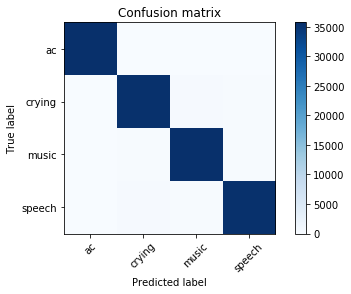

In [27]:
cm = confusion_matrix(y_holdout, holdout_pred_rbf)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_holdout_mySVM_100ms_rbf_mani.png',dpi=150)

Confusion matrix, without normalization


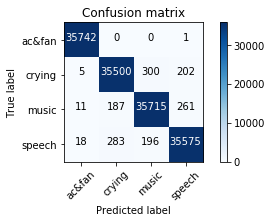

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout, holdout_pred_rbf)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['ac&fan', 'crying','music', 'speech'],
                      title='Confusion matrix')

plt.savefig('kfold1.png')

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.99 0.01 0.01]
 [0.   0.01 0.99 0.01]
 [0.   0.01 0.01 0.99]]


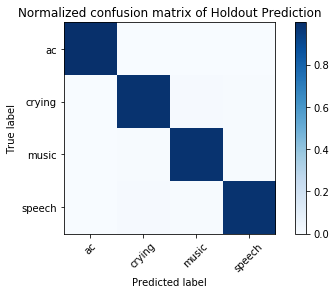

In [28]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, Label, title='Normalized confusion matrix of Holdout Prediction')
plt.savefig('norm_cm_holdout_mySVM_100_rbf_mani.png',dpi=150)
plt.show()

Confusion matrix, without normalization


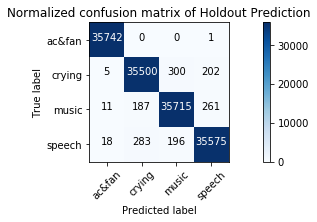

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout, holdout_pred_rbf)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(10,3))
plot_confusion_matrix(cnf_matrix, classes=['ac&fan', 'crying','music', 'speech'],
                      title='Normalized confusion matrix of Holdout Prediction')

plt.savefig('kfold2.png')

In [29]:
print(classification_report(y_holdout, holdout_pred_rbf))

              precision    recall  f1-score   support

          ac       1.00      1.00      1.00     35743
      crying       0.99      0.99      0.99     36007
       music       0.99      0.99      0.99     36174
      speech       0.99      0.99      0.99     36072

   micro avg       0.99      0.99      0.99    143996
   macro avg       0.99      0.99      0.99    143996
weighted avg       0.99      0.99      0.99    143996



In [30]:
model_prob_rbf = loaded_model_rbf.predict_proba(X_holdout) ##need prob for getting logloss
rbf_log_loss = log_loss(y_holdout, model_prob_rbf)
print("Log loss score of Holdout data for RBF kernel: {}".format(rbf_log_loss))

Log loss score of Holdout data for RBF kernel: 0.03325325415086988


## Loading Saved Model

In [2]:
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import time

In [3]:
filename = '/home/bsplab/Desktop/manikanta/SVM_Kflod/SVM_100ms_Rbf_model_mani.save' # call first saved model file

In [4]:
 # load the model from disk
loaded_model_rbf1 = joblib.load(open(filename, 'rb'))

### A

In [5]:
df1=pd.read_csv("/home/bsplab/Desktop/manikanta/SVM_Kflod/Testing_100ms/CRYING/crying_testing.csv",na_values=['NA','?'])
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")
df1.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-10.166330,-28.840257,-37.230772,14.160532,-10.673806,3.915022,10.506053,9.558074,3.383239,-2.278555,-4.451030,-3.077933,-1.077127
1,-9.132246,-28.308959,-39.586994,19.144334,-16.303967,6.448080,4.509218,5.940498,0.490428,0.088990,-2.799367,-2.585552,2.802776
2,-8.793318,-26.725370,-39.885100,14.762905,-21.725920,8.523211,-2.380727,5.415342,-5.052203,3.935676,2.095260,3.037759,6.023214
3,-8.566548,-25.436487,-37.422073,14.051592,-29.393727,5.823137,-8.774367,3.093728,-6.019697,2.182583,2.267267,4.949162,2.867329
4,-8.246559,-25.085498,-33.691972,18.270865,-35.307783,4.511325,-10.158296,2.634234,-5.470373,1.663351,0.142699,2.060347,2.477675


In [6]:
scaler_file = "/home/bsplab/Desktop/manikanta/SVM_Kflod/my_scaler_100.save"
scaler = joblib.load(scaler_file) 

In [7]:
X = scaler.transform(df1) ## Performing preprocessing on tested data

In [ ]:
tic=time.time()
holdout_pred_rbf1 = loaded_model_rbf1.predict(X)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

In [9]:
p1=holdout_pred_rbf1.size
print("The size of prediction " + str (p1))
a1=sum(holdout_pred_rbf1=="crying")
print("Total no. of predcited crying "+str(a1))
Acc1=a1/p1*100
print("The accuracy os the new environment crying data is "+ str(Acc1)+ " percent")

The size of prediction 71997
Total no. of predcited crying 67024
The accuracy os the new environment crying data is 93.09276775421198 percent


### V

In [11]:
df6=pd.read_csv("/home/bsplab/Desktop/manikanta/SVM_Kflod/Testing_100ms/FAN_AC/acfan_testing.csv",na_values=['NA','?'])
df6.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")

X6= scaler.transform(df6) ## Direct Do this
tic=time.time()
holdout_pred_rbf6 = loaded_model_rbf1.predict(X6)
toc=time.time()
print(str(1000*(toc-tic))+"ms")
p6=holdout_pred_rbf6.size
print("The size of prediction " + str (p6))
a6=sum(holdout_pred_rbf6=="ac")
print("Total no. of predcited fan&ac "+str(a6))
Acc6=a6/p6*100
print("The accuracy of the new environment fan&ac data is "+ str(Acc6)+ " percent")

47414.23749923706ms
The size of prediction 71997
Total no. of predcited fan&ac 62364
The accuracy of the new environment fan&ac data is 86.62027584482686 percent


In [12]:
df7=pd.read_csv("/home/bsplab/Desktop/manikanta/SVM_Kflod/Testing_100ms/MUSIC/music_testing.csv",na_values=['NA','?'])
df7.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
#filename_write = os.path.join(path,"7class-out-of-sample_mySVM_500ms.csv")
df7.head()
X7= scaler.transform(df7) ## Direct Do this
tic=time.time()
holdout_pred_rbf7 = loaded_model_rbf1.predict(X7)
toc=time.time()
print(str(1000*(toc-tic))+"ms")
p7=holdout_pred_rbf7.size
print("The size of prediction " + str (p7))
a7=sum(holdout_pred_rbf7=="music")
print("Total no. of predcited music "+str(a7))
Acc7=a7/p7*100
print("The accuracy of the new environment music data is "+ str(Acc7)+ " percent")

47789.74199295044ms
The size of prediction 71997
Total no. of predcited music 65746
The accuracy of the new environment music data is 91.31769379279692 percent


In [13]:
df4=pd.read_csv("/home/bsplab/Desktop/manikanta/SVM_Kflod/Testing_100ms/SPEECH/speech_testing.csv",na_values=['NA','?'])
df4.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']

X4= scaler.transform(df4) ## Direct Do this

tic=time.time()
holdout_pred_rbf4 = loaded_model_rbf1.predict(X4)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

p4=holdout_pred_rbf4.size
print("The size of prediction " + str (p4))
a4=sum(holdout_pred_rbf4=="speech")
print("Total no. of predcited speech "+str(a4))
Acc4=a4/p4*100
print("The accuracy of the new environment speech data is "+ str(Acc4)+ " percent")

46579.66923713684ms
The size of prediction 71997
Total no. of predcited speech 64279
The accuracy of the new environment speech data is 89.28010889342612 percent
